In [1]:
# https://github.com/dadejecova/Natural-Language-Python/blob/main/dataset/trainset.csv
# We're going to install those libraries
!pip install transformers
!pip install sentencepiece
!pip install rouge-score

# GPUT4 is the environment that we'll use

In [2]:
import transformers

transformers.__version__

'4.52.3'

In [3]:
import torch

import pandas as pd

from transformers import T5Tokenizer, T5ForConditionalGeneration

from transformers.optimization import Adafactor

from rouge_score import rouge_scorer

In [4]:
import io
import requests
import pandas as pd

In [5]:

url = 'https://raw.githubusercontent.com/dadejecova/Natural-Language-Python/main/dataset/trainset.csv'
response = requests.get(url)

In [6]:
if response.status_code == 200:
  #we read this with pnds
  restaurant_df = pd.read_csv(io.StringIO(response.text))
  print(restaurant_df.sample(10))
else:
  print("Failed to fetch Datset")

                                                      mr  \
10595  name[Alimentum], food[Chinese], priceRange[les...   
28962  name[The Mill], eatType[coffee shop], food[Ind...   
5178   name[The Waterman], food[Chinese], priceRange[...   
15317  name[Cocum], eatType[coffee shop], food[Italia...   
38732  name[The Golden Palace], eatType[restaurant], ...   
15568  name[The Olive Grove], eatType[restaurant], ar...   
23491  name[Fitzbillies], food[French], priceRange[le...   
37453  name[The Vaults], food[English], priceRange[hi...   
3421   name[The Golden Palace], eatType[restaurant], ...   
20451  name[Alimentum], food[Fast food], priceRange[h...   

                                                     ref  
10595  A cheap Chinese place in City Centre is called...  
28962  The Mill is a coffee shop that serves Indian f...  
5178   The Waterman is a child-friendly, moderately p...  
15317  Cocum coffee shop is a coffee shop that is ver...  
38732  The restaurant with prices more than 

In [7]:
restaurant_df.shape

(42061, 2)

In [8]:
restaurant_df['mr'][3]

'name[The Mill], eatType[coffee shop], food[French], priceRange[£20-25], area[riverside], near[The Sorrento]'

In [9]:
restaurant_df['ref'][3]

'Located near The Sorrento is a French Theme eatery and coffee shop called The Mill, with a price range at £20-£25 it is in the riverside area.'

In [10]:
restaurant_df_sampled = restaurant_df.sample(frac = 0.3)

restaurant_df_sampled.shape

(12618, 2)

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [12]:
tokenizer = T5Tokenizer.from_pretrained("t5-small", legacy=False)

tokenizer

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


T5Tokenizer(name_or_path='t5-small', vocab_size=32000, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_4

In [13]:
tokens = tokenizer.tokenize("very budget-friendly restaurant")
tokens

['▁very', '▁budget', '-', 'friendly', '▁restaurant']

In [14]:
ids = tokenizer.convert_tokens_to_ids(tokens)
ids

[182, 1487, 18, 4905, 2062]

In [15]:
model = T5ForConditionalGeneration.from_pretrained("t5-small", return_dict = True)

print(model)

model = model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [16]:
restaurant_df['mr'][10]

'name[Browns Cambridge], food[Fast food], area[riverside], familyFriendly[no], near[The Sorrento]'

In [17]:
model.eval()

# Batch
inputs_ids = tokenizer.encode("name[Browns Cambridge], food[Fast food], area[riverside], familyFriendly[no], near[The Sorrento]", return_tensors = "pt")

inputs_ids


tensor([[  564,  6306,   279,  3623,    29,     7, 10096, 13679,   542,  6306,
           371,     9,     7,    17,   542, 13679,   616,  6306,  5927,    49,
          1583, 13679,   384, 17701,   120,  6306,    29,    32, 13679,  1084,
          6306,   634,   264,    52,  5320,    32,   908,     1]])

In [18]:
inputs_ids = inputs_ids.to(device)

outputs = model.generate(inputs_ids, max_new_tokens=50)

outputs

tensor([[    0,   465,    51,  6306,   279,  3623,    29,     7, 10096, 13679,
           542,  6306,   371,     9,     7,    17,   542, 13679,   616,  6306,
          5927,    49,  1583, 13679,   384, 17701,   120,  6306,    29,    32,
         13679,  1084,  6306,   634,   264,    52,  5320,    32,   908,     1]],
       device='cuda:0')

In [19]:
tokenizer.decode(outputs[0])

'<pad> Nom[Browns Cambridge], food[Fast food], area[riverside], familyFriendly[no], near[The Sorrento]</s>'

In [20]:
# Reference summary
reference_text = "Bibimbap house is a moderately priced restaurant who's main cuisine is English Food."
predicted_text = "Bibimbap house is a moderately priced restaurant who's main cuisine is English Food."

# Initialize the Rougue Scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate the scores
rouge_scores = scorer.score(reference_text, predicted_text)

# print roughe score
for metric, scores in rouge_scores.items():
  print(f'{metric}:')
  print(f'  Precision: {scores.precision}')
  print(f'  Recall: {scores.recall}')
  print(f'  F1 Score: {scores.fmeasure}')

rouge1:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0
rouge2:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0
rougeL:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0


In [21]:
# Another example
reference_text = "Bibimbap house is a moderately priced restaurant who's main cuisine is English Food."
predicted_text = "Bibimbap house is a fairly priced restaurant seving English Food"

# Initialize the Rougue Scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate the scores
rouge_scores = scorer.score(reference_text, predicted_text)

# print roughe score
for metric, scores in rouge_scores.items():
  print(f'{metric}:')
  print(f'  Precision: {scores.precision}')
  print(f'  Recall: {scores.recall}')
  print(f'  F1 Score: {scores.fmeasure}')

rouge1:
  Precision: 0.8
  Recall: 0.5714285714285714
  F1 Score: 0.6666666666666666
rouge2:
  Precision: 0.5555555555555556
  Recall: 0.38461538461538464
  F1 Score: 0.4545454545454546
rougeL:
  Precision: 0.8
  Recall: 0.5714285714285714
  F1 Score: 0.6666666666666666


In [22]:
# Another example 2
reference_text = "Bibimbap house is a moderately priced restaurant who's main cuisine is English Food."
predicted_text = "House is a restaurant serving French food"

# Initialize the Rougue Scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate the scores
rouge_scores = scorer.score(reference_text, predicted_text)

# print roughe score
for metric, scores in rouge_scores.items():
  print(f'{metric}:')
  print(f'  Precision: {scores.precision}')
  print(f'  Recall: {scores.recall}')
  print(f'  F1 Score: {scores.fmeasure}')

rouge1:
  Precision: 0.7142857142857143
  Recall: 0.35714285714285715
  F1 Score: 0.4761904761904762
rouge2:
  Precision: 0.3333333333333333
  Recall: 0.15384615384615385
  F1 Score: 0.21052631578947367
rougeL:
  Precision: 0.7142857142857143
  Recall: 0.35714285714285715
  F1 Score: 0.4761904761904762


In [23]:
# Training the T5 Small model

In [24]:
optimizer = Adafactor(
    model.parameters(),
    lr = 1e-6,
    eps = (1e-30, 1e-3),
    clip_threshold = 1.0,
    decay_rate = -0.8,
    beta1 = None,
    weight_decay = 0.0,
    relative_step = False,
    scale_parameter = False,
    warmup_init = False
    )

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(restaurant_df_sampled, test_size = 0.2, random_state = 123)

X_train.shape, X_val.shape

((10094, 2), (2524, 2))

In [26]:
X_val

,mr,ref
11354,"name[Strada], food[French], priceRange[less th...","Located near Rainbow Vegetarian Café, Strada i..."
27537,"name[Bibimbap House], food[Japanese], area[riv...","Near The Rice Boat in the riverside area, is a..."
16047,"name[Cocum], eatType[coffee shop], food[French...",I would give Cocum a 3 out of 5 rating. This i...
23457,"name[The Golden Curry], food[Chinese], custome...","Near Café Rouge, in the city centre area, is f..."
22506,"name[The Wrestlers], eatType[coffee shop], foo...",The Wrestlers is a kid friendly coffee shop lo...
...,...,...
4667,"name[The Phoenix], food[Japanese], priceRange[...",The Phoenix is a low priced Japanese restauran...
12272,"name[Browns Cambridge], eatType[coffee shop], ...",Browns Cambridge serves Fast food in a coffee ...
3452,"name[The Olive Grove], eatType[pub], food[Chin...",The Olive Grove is a pub that provides Chinese...
34000,"name[The Punter], eatType[coffee shop], food[I...",Although the Indian food served at the coffee ...


In [27]:
batch_size = 8

num_of_epoch = 10

In [28]:
loss_stats = {
    "train": [],
    "val": []
}

In [29]:
for epoch in range(0, num_of_epoch):
  print("Running epoch: {}".format(epoch + 1))
  # Training mode
  model.train()
  train_running_loss = 0

  num_of_batches = len(X_train) / batch_size

  for i in range(int(num_of_batches)):
    # Get the batch
    X_train_batch = []
    y_train_batch = []

    # batchXbatchXbatchXbatch
    batch_df = X_train[i * batch_size: i * batch_size + batch_size]

    # Target to predict
    for _, row in batch_df.iterrows():
      X_train_row = row["mr"]
      y_train_row = row["ref"]

      X_train_batch.append(X_train_row)
      y_train_batch.append(y_train_row)
    #imput & target Text
    X_train_batch = tokenizer.batch_encode_plus(X_train_batch, padding = True, truncation = True,
                                                max_length = 256, return_tensors = "pt")["input_ids"]
    y_train_batch = tokenizer.batch_encode_plus(y_train_batch, padding = True, truncation = True,
                                                max_length = 256, return_tensors = "pt")["input_ids"]

    X_train_batch = X_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)

    # Clear the gradients
    optimizer.zero_grad()

    # Forward propagation
    train_outputs = model(input_ids = X_train_batch, labels = y_train_batch)

    train_loss = train_outputs.loss
    train_loss.backward()

    train_loss_num = train_loss.item()
    train_running_loss += train_loss_num

    #updating the params
    optimizer.step()

  train_loss = train_running_loss / int(num_of_batches)

  # validation
  with torch.no_grad():
    val_runningloss = 0

    model.eval()
    num_of_batches = len(X_val) / batch_size

    for i in range(int(num_of_batches)):
      X_val_batch = []
      y_val_batch = []

      val_batch_df = X_val[i * batch_size: i * batch_size + batch_size]

      for idx, row in val_batch_df.iterrows():
        X_val_row = row["mr"]
        y_val_row = row["ref"]

        X_val_batch.append(X_val_row)
        y_val_batch.append(y_val_row)

      X_val_batch = tokenizer.batch_encode_plus(X_val_batch, padding = True, truncation = True,
                                                max_length = 256, return_tensors = "pt")["input_ids"]
      y_val_batch = tokenizer.batch_encode_plus(y_val_batch, padding = True, truncation = True,
                                                max_length = 256, return_tensors = "pt")["input_ids"]

      X_val_batch = X_val_batch.to(device)
      y_val_batch = y_val_batch.to(device)

      val_outputs = model(input_ids = X_val_batch, labels = y_val_batch)

      val_loss = val_outputs.loss

      val_loss_num = val_loss.item()
      val_runningloss += val_loss_num

  val_loss = val_runningloss / int(num_of_batches)

  loss_stats["train"].append(train_loss)
  loss_stats["val"].append(val_loss)

  print(f"Epoch {epoch+1:01} | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}")

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Running epoch: 1
Epoch 1 | Train Loss: 4.360 | Val Loss: 2.539
Running epoch: 2
Epoch 2 | Train Loss: 3.401 | Val Loss: 2.139
Running epoch: 3
Epoch 3 | Train Loss: 2.865 | Val Loss: 1.878
Running epoch: 4
Epoch 4 | Train Loss: 2.435 | Val Loss: 1.709
Running epoch: 5
Epoch 5 | Train Loss: 2.146 | Val Loss: 1.607
Running epoch: 6
Epoch 6 | Train Loss: 1.954 | Val Loss: 1.514
Running epoch: 7
Epoch 7 | Train Loss: 1.830 | Val Loss: 1.432
Running epoch: 8
Epoch 8 | Train Loss: 1.732 | Val Loss: 1.371
Running epoch: 9
Epoch 9 | Train Loss: 1.657 | Val Loss: 1.327
Running epoch: 10
Epoch 10 | Train Loss: 1.598 | Val Loss: 1.293


In [30]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats). \
    reset_index().melt(id_vars = ["index"]). \
    rename(columns = {"index": "epochs"})

train_val_loss_df.head()

,epochs,variable,value
0,0,train,4.359760
1,1,train,3.400552
2,2,train,2.864515
3,3,train,2.435202
4,4,train,2.146423


Text(0.5, 1.0, 'Train-Val Loss vs Epoch')

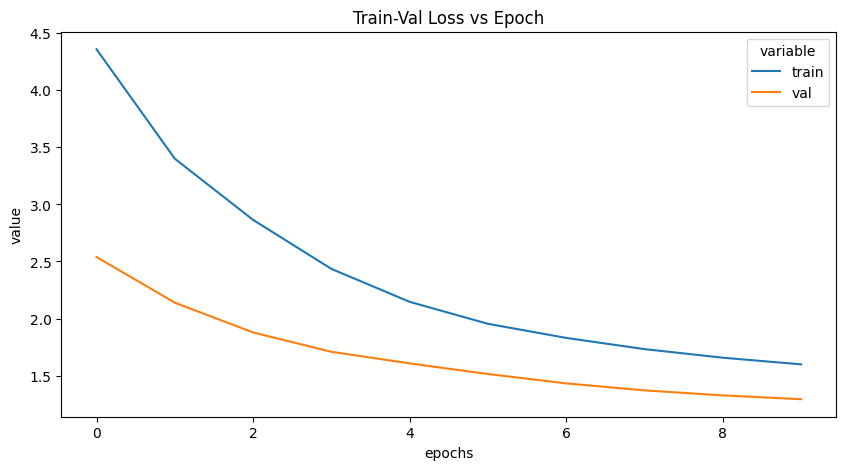

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))

sns.lineplot(data = train_val_loss_df, x = "epochs", y = "value", hue = "variable"
).set_title("Train-Val Loss vs Epoch")

In [32]:
# The losses for both, training data and validation fall over time.

In [33]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer = True)

In [34]:
X_val.sample(5)

,mr,ref
7939,"name[The Cambridge Blue], eatType[restaurant],...",There is a fast food restaurant called The Cam...
1376,"name[Wildwood], eatType[pub], food[French], pr...",Pub with customer rating of 5 out of 5 sells F...
25114,"name[Aromi], eatType[coffee shop], food[Italia...",Aromi coffee Shop is located in city center pr...
34975,"name[The Olive Grove], eatType[pub], priceRang...",The Olive Grove is a pub that offers family ar...
16691,"name[The Vaults], food[Fast food], priceRange[...",A fast food venue named The Vaults has a moder...


In [37]:
X_val["mr"][7939]

'name[The Cambridge Blue], eatType[restaurant], food[Fast food], customer rating[average]'

In [38]:
model.eval()

input_ids = tokenizer.encode(X_val["mr"][7939], return_tensors = "pt")

input_ids = input_ids.to(device)

outputs = model.generate(input_ids, max_new_tokens = 100)

predicted_text = tokenizer.decode(outputs[0])

predicted_text

'<pad> The Cambridge Blue is a restaurant that serves food that is not a good restaurant. It is rated as the average customer rating.</s>'

In [39]:
predicted_text = predicted_text.strip(' <>/pads')

predicted_text

'The Cambridge Blue is a restaurant that serves food that is not a good restaurant. It is rated as the average customer rating.'

In [40]:
reference_text = X_val["ref"][7939]

reference_text

'There is a fast food restaurant called The Cambridge Blue with an average customer rating.'

In [41]:
rouge_scores = scorer.score(reference_text, predicted_text)

for metric, scores in rouge_scores.items():
    print(f'{metric}:')
    print(f'  Precision: {scores.precision}')
    print(f'  Recall: {scores.recall}')
    print(f'  F1 Score: {scores.fmeasure}')

rouge1:
  Precision: 0.43478260869565216
  Recall: 0.6666666666666666
  F1 Score: 0.5263157894736841
rouge2:
  Precision: 0.22727272727272727
  Recall: 0.35714285714285715
  F1 Score: 0.2777777777777778
rougeL:
  Precision: 0.34782608695652173
  Recall: 0.5333333333333333
  F1 Score: 0.4210526315789474


In [42]:
def generate_text_and_compute_score(random_index):

  input_ids = tokenizer.encode(X_val["mr"][random_index], return_tensors = "pt")
  input_ids = input_ids.to(device)
  outputs = model.generate(input_ids, max_new_tokens = 100)

  predicted_text = tokenizer.decode(outputs[0])
  predicted_text = predicted_text.strip(' <>/pads')

  reference_text = X_val["ref"][random_index]

  rouge_scores = scorer.score(reference_text, predicted_text)

  print("Mr: ", X_val["mr"][random_index])
  print("Reference: ", reference_text)
  print("Predicted: ", predicted_text)

  for metric, scores in rouge_scores.items():
    print(f'{metric}:')
    print(f'  Precision: {scores.precision}')
    print(f'  Recall: {scores.recall}')
    print(f'  F1 Score: {scores.fmeasure}')

In [44]:
generate_text_and_compute_score(25114)

Mr:  name[Aromi], eatType[coffee shop], food[Italian], customer rating[5 out of 5], area[city centre], familyFriendly[yes]
Reference:  Aromi coffee Shop is located in city center providing Italian food. Have 5 out of 5 costumer rating and family-friendly too.
Predicted:  Aromi is a coffee shop in the city centre and is a local coffee shop that serves Italian food.
rouge1:
  Precision: 0.47368421052631576
  Recall: 0.4090909090909091
  F1 Score: 0.43902439024390244
rouge2:
  Precision: 0.1111111111111111
  Recall: 0.09523809523809523
  F1 Score: 0.10256410256410256
rougeL:
  Precision: 0.3684210526315789
  Recall: 0.3181818181818182
  F1 Score: 0.3414634146341463


In [45]:
generate_text_and_compute_score(34975)

Mr:  name[The Olive Grove], eatType[pub], priceRange[less than £20], area[city centre], familyFriendly[yes]
Reference:  The Olive Grove is a pub that offers family area and it has a price range less than £20. It is located in the centre.
Predicted:  The Olive Grove is a pub in the city centre, with a price range less than £20.
rouge1:
  Precision: 0.8823529411764706
  Recall: 0.6
  F1 Score: 0.7142857142857143
rouge2:
  Precision: 0.6875
  Recall: 0.4583333333333333
  F1 Score: 0.5499999999999999
rougeL:
  Precision: 0.7058823529411765
  Recall: 0.48
  F1 Score: 0.5714285714285713
